<a href="https://colab.research.google.com/github/kaniarasann/AI-Expert-Roadmap/blob/main/09_Human_in_the_Loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [137]:
#!pip install langchain langgraph langchain_groq pydantic

In [138]:
from typing import Annotated, List,Literal
from pydantic import BaseModel, Field
import operator
from langchain_groq import ChatGroq
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, BaseMessage
from langgraph.constants import Send
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_groq import ChatGroq
from langgraph.prebuilt import ToolNode,tools_condition
from IPython.display import display, Image
from google.colab import userdata
from langgraph.checkpoint.memory import MemorySaver
import pprint

groq_key = userdata.get('groq_key')

In [139]:
llm = ChatGroq(api_key=groq_key, model="moonshotai/kimi-k2-instruct",)

In [140]:
def sum_two_number(a: int, b: int) -> int:
  """Sum two numbers
     args
     a: int
     b: int
     return: int
  """
  return a + b

In [141]:
def subract_two_number(a: int, b: int) -> int:
  """Subract two numbers
     args
     a: int
     b: int
     return: int
  """
  return a - b

In [142]:
llm_tool_calling = llm.bind_tools([sum_two_number,subract_two_number])

In [143]:
def assistant(state:MessagesState):
  template = SystemMessage(content="Your are a helpful assistant tasked with perfoming subraction and addition on the given inputs")
  res = llm_tool_calling.invoke([template])+state['messages']
  return {"message":[res]}


In [144]:
graph = StateGraph(MessagesState)

In [145]:
graph.add_node("llm",assistant)
graph.add_node("tools",ToolNode([sum_two_number,subract_two_number]))

graph.add_edge(START,"llm")
graph.add_conditional_edges("llm",tools_condition)
graph.add_edge("tools","llm")
graph.add_edge("llm",END)

In [146]:
checkpointer = MemorySaver()
graph_builder = graph.compile(checkpointer=checkpointer,interrupt_before=["llm"])

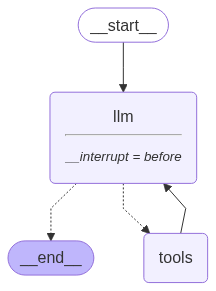

In [147]:
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [148]:
config = {"configurable": {"thread_id": "1"}}

In [150]:
for event in graph_builder.stream({"messages":HumanMessage(content="Multiply 2 and 3")},config,stream_mode="values"):
  pprint.pprint(event['messages'])

[HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='196f7258-a9b2-41f9-bff4-c27eb594319a'),
 HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='89d2e0f0-77c2-4528-a609-d5fe8610e721')]
